<a href="https://colab.research.google.com/github/msiplab/EicEngLabIV/blob/master/example02_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験Ⅳ－２　時系列データの分析

1. サンプルデータの読み込み
1. 平均 $\mu$ と分散 $\gamma_0$ の推定
1. 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

新潟大学工学部工学科　電子情報通信プログラム

## 準備

In [1]:
#!pip install bs4
!pip install japanize-matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore') #警告を無視（コメントアウト推奨）

from urllib import request
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import pandas.tseries.offsets as offsets
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib #日本語化matplotlib
sns.set(font="IPAexGothic") #日本語フォント設定

## Webからの水位データの読み込み

新潟県河川防災情報システムより
http://doboku-bousai.pref.niigata.jp/kasen/index.html

河川ライブ映像 http://www.hrr.mlit.go.jp/shinano/live/map1.html# （小千谷市11番目）

以下のPythonライブラリを利用
- urllib
- bs4


In [2]:
# Web スクレイピングかファイル入力かを選択
isWebScraping = True # Web スクレイピングを行う場合は True に設定

# 解析期間の設定
dts = '2024040100' # 開始日時
dte = '2024041023' # 終了日時

# ファイルをアップロードする
#from google.colab import files
#uploaded_file = files.upload()
#filename = next(iter(uploaded_file))
#print(filename)

#観測データのファイル
#filename = './data/practice02_01.csv'

if not isWebScraping:
    # ファイルからの水位情報抽出
    # CSVファイルの読み込み
    df_full = pd.read_csv(filename)
    df_full['t'] = pd.to_datetime(df_full['t'])
    strtitle = filename
    # タイムスタンプの設定
    dts00 = pd.to_datetime(dts+'00').tz_localize('Asia/Tokyo')
    dte00 = pd.to_datetime(dte+'00').tz_localize('Asia/Tokyo')
else:
    # Web スクレイピングを行う場合の設定
    # 取得したい水位観測所の情報を指定する
    # 水位観測所IDは、下記URLから取得可能
    # http://doboku-bousai.pref.niigata.jp/kasen/servlet/bousaiweb.servletBousaiGraph?ga=4&gk=0&gn=0&gl=0&gw=0&go=0&omp=0&opn=0&spn=0&tvm=0&tsw=0&sv=3&dk=2&mp=0&no=0&fn=0&pg=6&sitept=0&unq=12062215494&nwg=0&tmg={0}&sn={1}&wsl=3&wl=1&rg=1&sy=gra_river&psn=0&=&nw=0&tm={0}&logflg=0

    # 水位観測所IDの設定
    loc = '260' #

    # 観測間隔の設定
    interval = 1 # hour

    # Webからの水位情報抽出
    dts00 = pd.to_datetime(dts+'00')
    dte00 = pd.to_datetime(dte+'00')
    td = dte00 - dts00
    durationinhours = int(td.total_seconds()/(3600))
    t = [ [] for idx in range(durationinhours) ]
    y = [ 0.0 for idx in range(durationinhours) ]
    idt = dts00
    idx = 0
    while idt < dte00:
        # 水位抽出日時の設定
        strdt = idt.strftime('%Y%m%d%H%M')
        ts = pd.to_datetime(idt).tz_localize('Asia/Tokyo')

        # URLの設定
        url = 'http://doboku-bousai.pref.niigata.jp/kasen/servlet/bousaiweb.servletBousaiGraph?ga=4&gk=0&gn=0&gl=0&gw=0&go=0&omp=0&opn=0&spn=0&tvm=0&tsw=0&sv=3&dk=2&mp=0&no=0&fn=0&pg=6&sitept=0&unq=12062215494&nwg=0&tmg={0}&sn={1}&wsl=3&wl=1&rg=1&sy=gra_river&psn=0&=&nw=0&tm={0}&logflg=0'.format(strdt,loc)

        # 指定した時刻の水位情報抽出
        response = request.urlopen(url)
        soup = BeautifulSoup(response)
        response.close()
        if idt == dts00:
            strtitle = soup.title.text.strip()
        #print(soup.find('td', class_='tableHeaderCast').text.strip())
        strwaterlevel = soup.find('td', class_='tableHeaderItemCen').text.strip().replace('m','')
        try:
            waterlevel = float(strwaterlevel)
        except ValueError as ve:
            waterlevel = np.nan

        # リストへのデータ登録
        t[idx] = ts
        y[idx] = waterlevel

        # 時間を更新
        idx += 1
        idt += offsets.Hour(interval)


## 時系列データをpandas.DataFrameオブジェクトに変換

pandas ライブラリの DataFrame オブジェクトに変換

- t: 時刻
- y: データの値


In [3]:
if not isWebScraping:
    # Localize the timestamps to match the timezone of the 't' column
    df_timeseries = df_full[(df_full.t>=dts00) & (df_full.t<=dte00)].copy()
    df_timeseries = df_timeseries.reset_index()
else:
    df_timeseries = pd.DataFrame({'t': t, 'y': y})
display(df_timeseries)

,t,y
0,2024-04-01 00:00:00+09:00,43.78
1,2024-04-01 01:00:00+09:00,43.73
2,2024-04-01 02:00:00+09:00,43.73
3,2024-04-01 03:00:00+09:00,43.72
4,2024-04-01 04:00:00+09:00,43.73
...,...,...
234,2024-04-10 18:00:00+09:00,44.86
235,2024-04-10 19:00:00+09:00,44.83
236,2024-04-10 20:00:00+09:00,44.81
237,2024-04-10 21:00:00+09:00,44.73


## 時系列データをプロット

- y: 原系列
- y_fillna: 欠損個所を前の値で補間


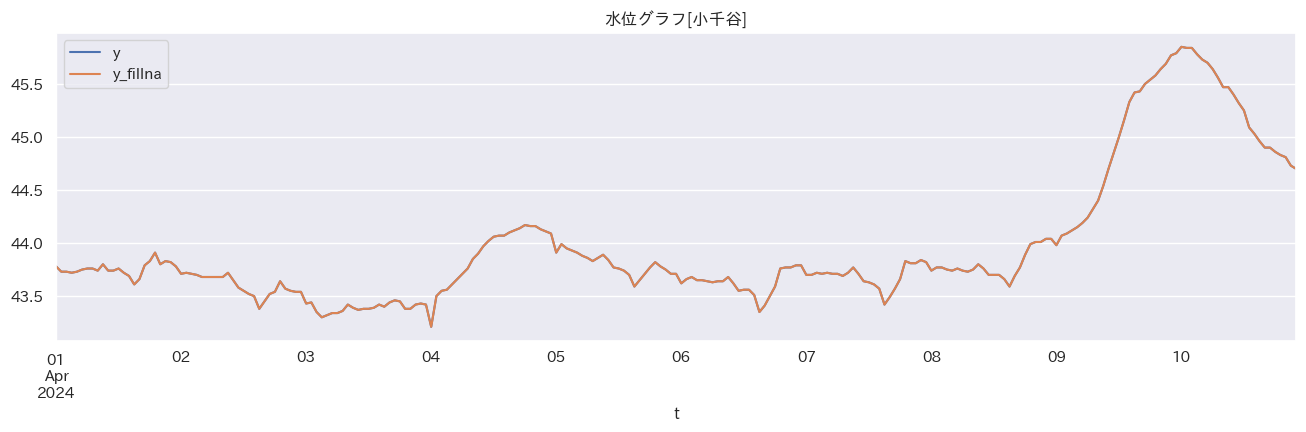

In [4]:
df_timeseries['y_fillna'] = df_timeseries['y'].fillna(method='ffill').astype(float)
ax = df_timeseries.plot(x='t', y=['y', 'y_fillna'], figsize=(16,4), title=strtitle)

ヒストグラムをプロット

Text(0.5, 1.0, '水位グラフ[小千谷]')

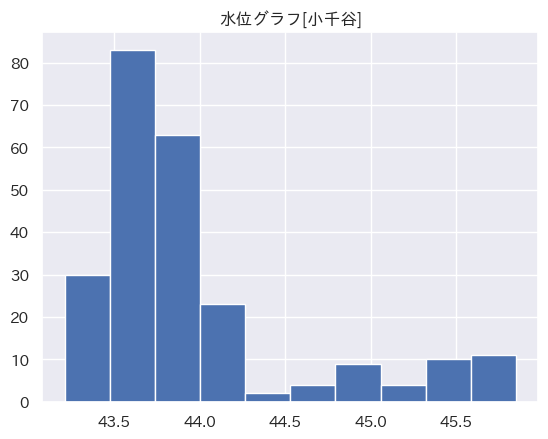

In [5]:
ax = df_timeseries.hist('y')
ax[0][0].set_title(strtitle)

## 平均 $\mu$ と分散 $\gamma_0$ の推定

- mean(): 標本平均を計算
- var(): 標本分散を計算

pandas.DataFrame オブジェクトのvar() メソッドのオプションで

- ddof = 0 とすると N で割る最尤推定
- ddof = 1 とすると (N-1)で割る不偏推定 ※デフォルト

In [6]:
y_series = df_timeseries['y']
mu = y_series.mean()
gamma0 = y_series.var(ddof=1)
print('平均 = {:f}, 分散 = {:f}'.format(mu,gamma0))

平均 = 43.970335, 分散 = 0.402288


## 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

y_series は pandas.Series のオブジェクトとなっている。
pandas.Seriesオブジェクトは以下のメソッドを備える。

- cov() は共分散の不偏推定を計算
- corr() は相関の不偏推定を計算

※不偏推定から最尤推定への切替はできない


In [7]:
nlags = 40
for lag in range(nlags+1):
    gammak = y_series.cov(y_series.shift(lag))
    rhok = y_series.corr(y_series.shift(lag))
    print('γ{0:d} = {1:f}, ρ{0:d} = {2:f}'.format(lag,gammak,rhok))

γ0 = 0.402288, ρ0 = 1.000000
γ1 = 0.400748, ρ1 = 0.994956
γ2 = 0.397764, ρ2 = 0.986713
γ3 = 0.393392, ρ3 = 0.975743
γ4 = 0.387858, ρ4 = 0.962145
γ5 = 0.381462, ρ5 = 0.946703
γ6 = 0.374241, ρ6 = 0.929590
γ7 = 0.366735, ρ7 = 0.911782
γ8 = 0.358480, ρ8 = 0.892741
γ9 = 0.349557, ρ9 = 0.872829
γ10 = 0.339604, ρ10 = 0.850892
γ11 = 0.328333, ρ11 = 0.827655
γ12 = 0.316273, ρ12 = 0.803256
γ13 = 0.303539, ρ13 = 0.778074
γ14 = 0.290147, ρ14 = 0.752110
γ15 = 0.276307, ρ15 = 0.724791
γ16 = 0.261785, ρ16 = 0.696944
γ17 = 0.247205, ρ17 = 0.669712
γ18 = 0.232639, ρ18 = 0.642880
γ19 = 0.218473, ρ19 = 0.617215
γ20 = 0.204499, ρ20 = 0.592534
γ21 = 0.190693, ρ21 = 0.569203
γ22 = 0.177056, ρ22 = 0.545954
γ23 = 0.163780, ρ23 = 0.523665
γ24 = 0.151176, ρ24 = 0.501903
γ25 = 0.137319, ρ25 = 0.475044
γ26 = 0.124124, ρ26 = 0.447766
γ27 = 0.111519, ρ27 = 0.420512
γ28 = 0.099588, ρ28 = 0.393361
γ29 = 0.088270, ρ29 = 0.366570
γ30 = 0.077839, ρ30 = 0.341327
γ31 = 0.068256, ρ31 = 0.316932
γ32 = 0.059334, ρ32 = 0.2941

## 時系列解析ライブラリ

時系列解析には，statsmodelsライブラリも利用できる。

- acovf() は自己共分散関数を計算
- acf() は自己相関関数を計算

各メソッドのオプション unbiased = True で不偏推定，Falseで最尤推定となる．



In [8]:
import statsmodels.api as sm
from statsmodels.tsa import stattools

#欠損値がある場合は nan が含まれる．
#欠損個所を補間したデータを使わない場合は以下の行をコメントアウトする
y_series = df_timeseries['y_fillna']

print('自己共分散関数')
y_acovf = stattools.acovf(y_series,unbiased=True)
display(y_acovf)
print('自己相関関数')
y_acf = stattools.acf(y_series,adjusted=True)
display(y_acf)


自己共分散関数


array([ 0.40060491,  0.39906157,  0.39607438,  0.39169673,  0.38615461,
        0.37974551,  0.37250767,  0.36497814,  0.35669389,  0.34772986,
        0.3377388 ,  0.3264063 ,  0.31427274,  0.3014554 ,  0.28795261,
        0.2739761 ,  0.25926707,  0.24448474,  0.22974268,  0.21539852,
        0.20126785,  0.18722949,  0.1733581 ,  0.15982355,  0.14691875,
        0.13269648,  0.11912272,  0.1061076 ,  0.0937344 ,  0.08193089,
        0.07098614,  0.06086632,  0.05137479,  0.04270262,  0.03485149,
        0.02786222,  0.02143722,  0.0157602 ,  0.01066219,  0.00620443,
        0.00168948, -0.00245797, -0.00624444, -0.00943132, -0.01190923,
       -0.0141711 , -0.01611762, -0.01744709, -0.01883174, -0.02126957,
       -0.02369356, -0.02599722, -0.02817324, -0.03001312, -0.03087253,
       -0.03126914, -0.03083472, -0.0307266 , -0.03100954, -0.03120621,
       -0.03172629, -0.03248412, -0.03357189, -0.03446695, -0.03591745,
       -0.03776614, -0.03987832, -0.04190872, -0.04359808, -0.04

自己相関関数


array([1.        , 0.99614748, 0.98869078, 0.97776318, 0.96392879,
       0.94793025, 0.92986297, 0.91106757, 0.89038823, 0.86801197,
       0.84307204, 0.81478358, 0.78449547, 0.7525005 , 0.71879452,
       0.68390599, 0.64718896, 0.61028893, 0.57348942, 0.53768317,
       0.50240985, 0.46736693, 0.43274082, 0.39895554])

## 原系列のコレログラムの表示

自己相関のグラフをコレログラムとよぶ。コレログラムは次のコマンドで表示できる。

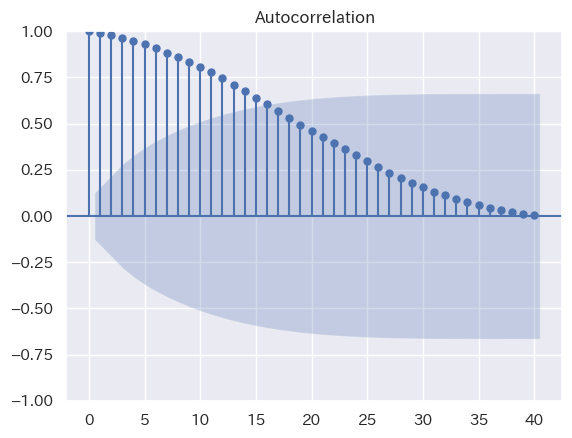

In [9]:
fig = sm.graphics.tsa.plot_acf(y_series,lags=nlags)

## 階差系列の分析

ひとつ前の値との差分をとった系列を階差系列とよぶ。

$\Delta y_n = y_{n} - y_{n-1}$


,t,y,y_fillna,y_diff
0,2024-04-01 00:00:00+09:00,43.78,43.78,NaN
1,2024-04-01 01:00:00+09:00,43.73,43.73,-0.05
2,2024-04-01 02:00:00+09:00,43.73,43.73,0.00
3,2024-04-01 03:00:00+09:00,43.72,43.72,-0.01
4,2024-04-01 04:00:00+09:00,43.73,43.73,0.01
...,...,...,...,...
234,2024-04-10 18:00:00+09:00,44.86,44.86,-0.04
235,2024-04-10 19:00:00+09:00,44.83,44.83,-0.03
236,2024-04-10 20:00:00+09:00,44.81,44.81,-0.02
237,2024-04-10 21:00:00+09:00,44.73,44.73,-0.08


<Axes: title={'center': '水位グラフ[小千谷]の階差系列'}, xlabel='t'>

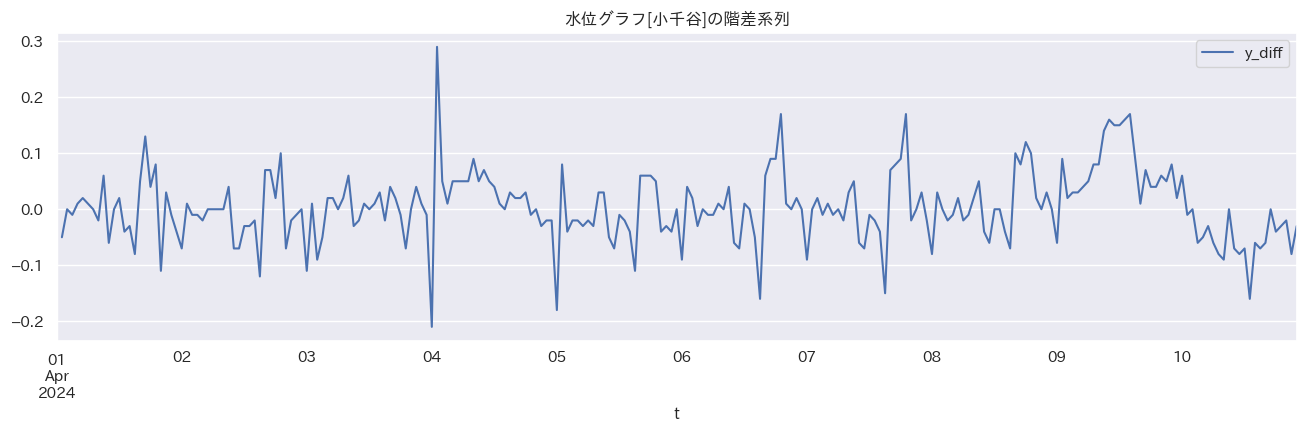

In [10]:
# 欠損データの補間を行わない場合
#df_timeseries['y_diff'] = df_timeseries['y'].diff()
# 欠損データを補間を行う場合
df_timeseries['y_diff'] = df_timeseries['y_fillna'].diff()
display(df_timeseries)
df_timeseries.plot(x='t', y='y_diff', figsize=(16,4), title='{}の階差系列'.format(strtitle))



ヒストグラムをプロット


Text(0.5, 1.0, '水位グラフ[小千谷]（階差）')

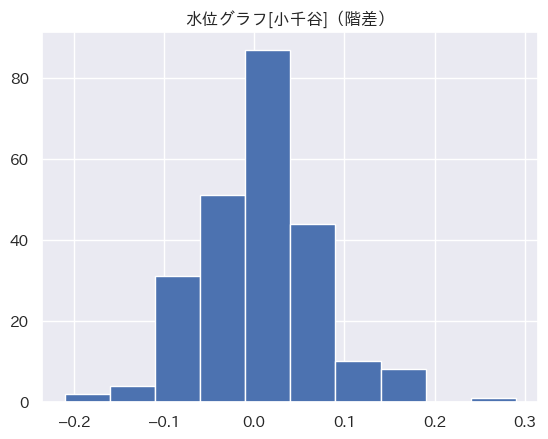

In [11]:
ax = df_timeseries.hist('y_diff')
ax[0][0].set_title(strtitle+'（階差）')

原系列 $y_n$ と階差系列 $\Delta y_n$ のCSVへの出力

In [12]:
#df_timeseries.to_csv('./data/sample02_03.csv',index=False)